In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(11)

In [2]:
def import_csv(full_path_to_file):
    # Reading CSV
    pd_dataframe = pd.read_csv(full_path_to_file, delimiter=';', decimal=',', skiprows=range(1, 3) ) # create_dataframe_from_excel_export("D:\\Users\\ewielinga\\ValidatieValTools&Handmatig\\UitkomstValTools\\uitkomst_export_15-4-2024.csv")
    
    # Replacing DateTime column name for more readable code
    pd_dataframe.rename(columns={'Locatie':'DatumTijd'}, inplace=True)
    # Convert datetime values from string/object to datetime64 type
    pd_dataframe['DatumTijd']= pd.to_datetime(pd_dataframe['DatumTijd'])

    # Check if read are all values in float64 format (as expected)
    check_data_types_not_float64 = pd_dataframe.select_dtypes(exclude=['float64']).dtypes
    if( len(check_data_types_not_float64) != 1 ):
        print('Column datatype intepretation fault, whilst reading csv file.')
        print('Only column="DatumTijd" should NOT be float64, check list printed below:')
        print(check_data_types_not_float64)
        return False

    return pd_dataframe

In [3]:
from main import falsify_by_bias
from main import falsify_by_skewness
from main import falsify_by_homoscedasticity_fixed
from main import falsify_by_outliers
from main import falsify_by_rate_change
from main import TimeSeriesIncidents

In [4]:
# SPH data
export_file_loc = "D:\\Shared\\FalsifyDataset\\scripts\\WK_PA_ValidatieGegevens-1" \
                "\\original_dataset\\Heiloo_origineel_naar_ValTools_2023.csv" 
start_date="2023-05-01"
end_date="2023-05-21"
pd_dataframe = import_csv(export_file_loc)
print(pd_dataframe.columns)
print(f"shape whole data: {pd_dataframe.shape}")

Index(['DatumTijd', 'HEIL_12-HE-slDH_FY21124', 'HEIL_12-HE-slDH_FT42502',
       'HEIL_12-HE-slDH_FY42503', 'HEIL_12-HE-slEO_FT31604',
       'HEIL_12-HE-slEO_FT31605', 'HEIL_12-HE-slEO_FT31471',
       'HEIL_12-HE-slEO_TT33401', 'HEIL_12-HE-slEO_TT33402',
       'HEIL_12-HE-slEO_QT31653',
       ...
       'HEIL_ZRG-IB-7320_FTT5', 'HEIL_ZRG-IB-7320_LT1', 'HEIL_ZRG-IB-7320_LT2',
       'HEIL_ZRG-IB-7322_FTT5', 'HEIL_ZRG-IB-7322_LT1', 'HEIL_ZRG-IB-7322_LT2',
       'HEIL_ZRG-IB-7321_FTT5', 'HEIL_ZRG-IB-7321_LT1',
       'HEIL_ZRG-IB-17508_FTT5', 'HEIL_ZRG-IB-17508_LT1'],
      dtype='object', length=142)
shape whole data: (525601, 142)


## Rate of change

In [5]:
# Select temperature
pd_single_timeseries =  pd_dataframe[['DatumTijd', 'HEIL_12-HE-wlBI_TT12405']]
#  Select a shorter period as sample
datetime_mask = (pd_single_timeseries['DatumTijd'] >= start_date) & (pd_single_timeseries['DatumTijd'] < end_date)
pd_to_falsify = pd_single_timeseries.loc[datetime_mask]
print(f"Total rows: {pd_to_falsify.shape[0]}")
print(f"Rows with values: {pd_to_falsify.iloc[:,1].count()}")
pd_to_falsify

Total rows: 28800
Rows with values: 5760


,DatumTijd,HEIL_12-HE-wlBI_TT12405
172800,2023-05-01 00:00:00+00:00,14.7793
172801,2023-05-01 00:01:00+00:00,NaN
172802,2023-05-01 00:02:00+00:00,NaN
172803,2023-05-01 00:03:00+00:00,NaN
172804,2023-05-01 00:04:00+00:00,NaN
...,...,...
201595,2023-05-20 23:55:00+00:00,16.5306
201596,2023-05-20 23:56:00+00:00,NaN
201597,2023-05-20 23:57:00+00:00,NaN
201598,2023-05-20 23:58:00+00:00,NaN


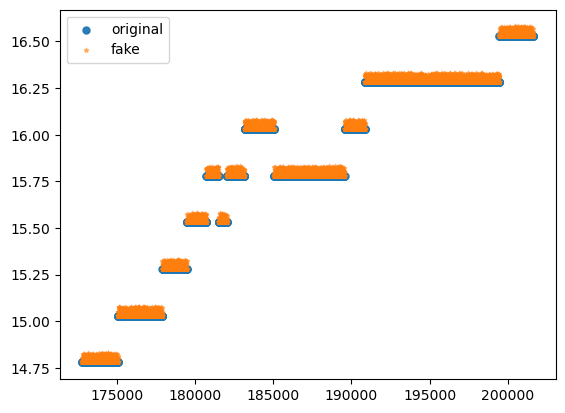

In [6]:
# Original & fake values for temperature
df =  falsify_by_rate_change(pd_to_falsify, exeeding_limit='bottom') # top
plt.scatter(x=pd_to_falsify.index, y=pd_to_falsify.iloc[:,1].values, edgecolors=None, s=25, alpha=.95, label="original")
plt.scatter(x=df.index,y=df.iloc[:,1].values, marker='*', edgecolors=None, s=10, alpha=.5, label="fake")
plt.legend()
plt.show()


## Several types of false data in a long-period time series

In [7]:
pd_single_timeseries =  pd_dataframe[['DatumTijd', 'HEIL_ZRG-IB-7321_LT1']]
# Falsify functions 
func_list = [
            falsify_by_outliers,
            falsify_by_bias, 
            falsify_by_skewness, 
            falsify_by_homoscedasticity_fixed,
            falsify_by_rate_change,
            ]
# Fractions of batches with fake data
sizes = [2.5, .4, 1, .3, .5, .01, .1, .9, 5, .2, .45, 1.2, .03]

Operations performed according to func_list:
 [3, 2, 2, 1, 0, 2, 2, 0, 3, 2, 3, 2, 2]


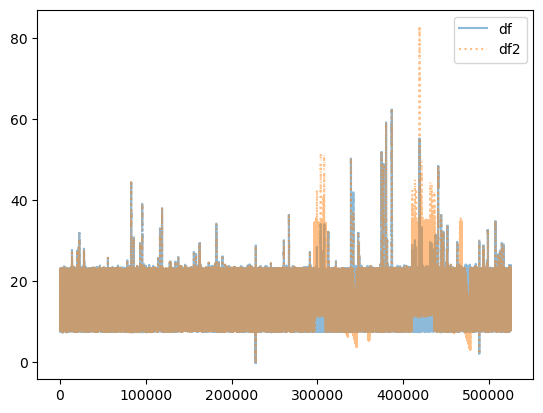

In [8]:
# Since the fake values are randomly created, it can be possible to get errors. 
# Just re-run this cell if errors appear
tsi = TimeSeriesIncidents(pd_single_timeseries=pd_single_timeseries, sizes=sizes, func_list=func_list)
_ = tsi.generate_incidents(p_event = 1e-6, behavior='increasing') # uniform
_ =  tsi.get_indices_indicents()
df_new = tsi.falsify_incidents()
print("Operations performed according to func_list:\n",
    f"{tsi.false_operations}")

plt.plot(pd_single_timeseries.iloc[:,1].values, linestyle='-', alpha=.5, label="df")
plt.plot(df_new.iloc[:,1].values, linestyle=':', alpha=.5, label="df2")
plt.legend()
plt.show()

## The same but using a short and random df

shape df argument: (200, 2)


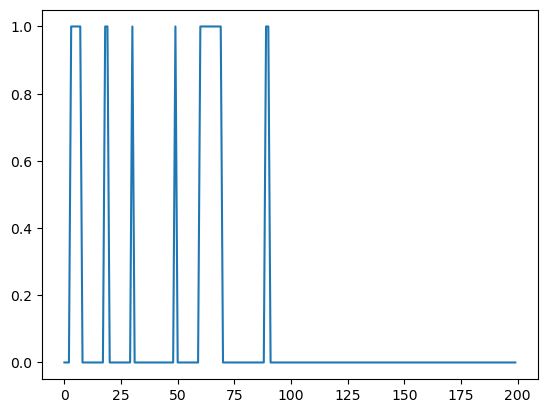

In [9]:
pd_single_timeseries =  pd.DataFrame(np.random.rand(200,2) * 45, columns=['Time','Foo'])
print(f"shape df argument: {pd_single_timeseries.shape}")

tsi = TimeSeriesIncidents(pd_single_timeseries=pd_single_timeseries, sizes=sizes, func_list=func_list)
_incidents = tsi.generate_incidents(p_event = 1e-1, behavior='uniform') # More probable because the df is smaller
plt.plot(_incidents*1)
plt.show()

Number of batches with indicents: 6
Operations performed according to func_list:
 [4, 2, 2, 1, 2, 0]


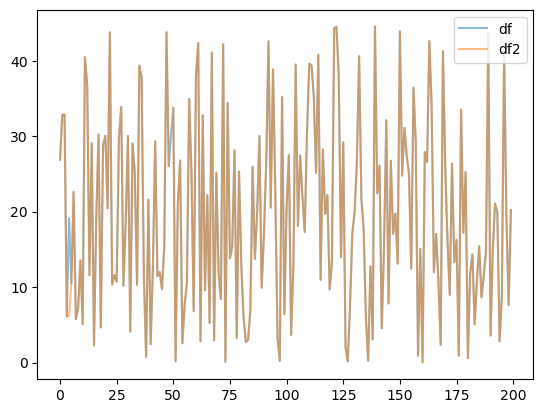

In [10]:
_batches =  tsi.get_indices_indicents()
print(f"Number of batches with indicents: {len(_batches)}")
df_new = tsi.falsify_incidents()
print("Operations performed according to func_list:\n",
    f"{tsi.false_operations}")

plt.plot(pd_single_timeseries.iloc[:,1].values, alpha=.5, label="df")
plt.plot(df_new.iloc[:,1].values, alpha=.5, label="df2")
plt.legend()
plt.show()